# Jupyter notebook sample

In [19]:


import correct
# Import libraries
import cv2
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import total
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from torch.utils.data import DataLoader
from torchvision import models
from torchvision.datasets import ImageFolder


In [20]:
face_cascade = cv2.CascadeClassifier("haarcascade_frontalface_default.xml")

In [21]:
def detect_face(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))

    if len(faces) == 0:
        return None  # No face detected

    x, y, w, h = faces[0]
    face = image[y:y+h, x:x+w]
    face = cv2.resize(face, (224, 224))
    return face

In [22]:
# Define dataset paths
train_dir = "CK_dataset/train"
test_dir = "CK_dataset/test"

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

train_dataset = ImageFolder(train_dir, transform=transform)
test_dataset = ImageFolder(test_dir, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [23]:
#load efficient model
efficientnet_model = models.efficientnet_b0(pretrained=True)
num_features = efficientnet_model.classifier[1].in_features
efficientnet_model.classifier[1] = nn.Linear(num_features, 6)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(efficientnet_model.parameters(), lr=0.001)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
efficientnet_model.to(device)

C:\Users\farha\DataspellProjects\AI_Assignment2\venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\farha\DataspellProjects\AI_Assignment2\venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [24]:
#training with test accuracy
num_epochs = 25
train_acc_list = []
test_acc_list = []
train_loss_list = []
test_loss_list = []

for epoch in range(num_epochs):
    runing_loss = 0.0
    correct = 0
    total = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = efficientnet_model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        runing_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    train_acc = 100* correct / total
    train_acc_list.append(train_acc)
    train_loss_list.append(runing_loss / len(train_loader))

    # Evaluation on the test set
    efficientnet_model.eval()
    correct_test = 0
    total_test = 0
    test_loss = 0.0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = efficientnet_model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total_test += labels.size(0)
            correct_test += predicted.eq(labels).sum().item()

    test_acc = 100 * correct_test / total_test
    test_acc_list.append(test_acc)
    test_loss_list.append(test_loss / len(test_loader))
    print(
        f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {runing_loss/len(train_loader):.4f},'
        f'Train Acc: {train_acc:.2f}%, Test Acc: {test_acc:.2f}%')

Epoch [1/25], Train Loss: 1.3853,Train Acc: 48.97%, Test Acc: 54.55%
Epoch [2/25], Train Loss: 2.0097,Train Acc: 23.17%, Test Acc: 27.27%
Epoch [3/25], Train Loss: 2.2938,Train Acc: 21.41%, Test Acc: 20.98%
Epoch [4/25], Train Loss: 1.7465,Train Acc: 21.11%, Test Acc: 20.98%
Epoch [5/25], Train Loss: 32.9207,Train Acc: 20.23%, Test Acc: 23.78%
Epoch [6/25], Train Loss: 52.4115,Train Acc: 17.01%, Test Acc: 9.09%
Epoch [7/25], Train Loss: 806.4907,Train Acc: 19.94%, Test Acc: 12.59%
Epoch [8/25], Train Loss: 2.8099,Train Acc: 22.58%, Test Acc: 25.17%
Epoch [9/25], Train Loss: 2.1734,Train Acc: 25.81%, Test Acc: 11.19%
Epoch [10/25], Train Loss: 468.0012,Train Acc: 14.96%, Test Acc: 24.48%
Epoch [11/25], Train Loss: 3.1007,Train Acc: 24.93%, Test Acc: 24.48%
Epoch [12/25], Train Loss: 1.7419,Train Acc: 21.41%, Test Acc: 20.98%
Epoch [13/25], Train Loss: 1.7007,Train Acc: 21.99%, Test Acc: 25.17%
Epoch [14/25], Train Loss: 1.6706,Train Acc: 25.22%, Test Acc: 25.17%
Epoch [15/25], Train Los

Final Test Accuracy: 25.41%


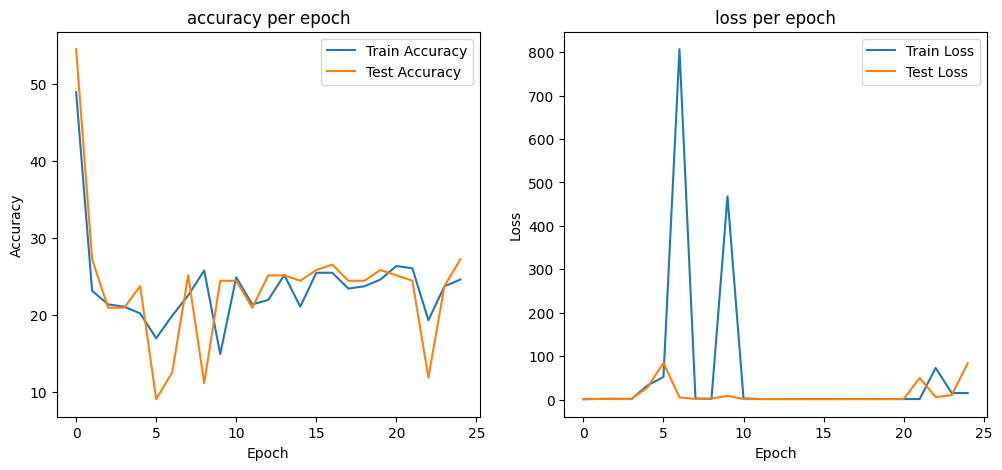

In [25]:
#final evaluation
efficientnet_model.eval()
y_true = []
y_pred = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = efficientnet_model(images)
        _, predicted = outputs.max(1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

final_test_accuracy = 100 * correct / total
print(f'Final Test Accuracy: {final_test_accuracy:.2f}%')

conf_matrix = confusion_matrix(y_true, y_pred)
cm_display = ConfusionMatrixDisplay(conf_matrix, display_labels=test_dataset.classes)


plt.figure(figsize=(12, 5))

#accuracy plots
plt.subplot(1, 2, 1)
plt.plot(train_acc_list, label='Train Accuracy')
plt.plot(test_acc_list, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('accuracy per epoch')

#loss plots
plt.subplot(1, 2, 2)
plt.plot(train_loss_list, label='Train Loss')
plt.plot(test_loss_list, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('loss per epoch')

plt.show()

In [26]:
train_dir = "JAFFE-[70,30]/train"
test_dir = "JAFFE-[70,30]/test"

train_dataset = ImageFolder(train_dir, transform=transform)
test_dataset = ImageFolder(test_dir, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [27]:
#load efficient model
efficientnet_model = models.efficientnet_b0(pretrained=True)
num_features = efficientnet_model.classifier[1].in_features
efficientnet_model.classifier[1] = nn.Linear(num_features, 6)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(efficientnet_model.parameters(), lr=0.001)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
efficientnet_model.to(device)

C:\Users\farha\DataspellProjects\AI_Assignment2\venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\farha\DataspellProjects\AI_Assignment2\venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [28]:
#training with test accuracy
num_epochs = 25
train_acc_list = []
test_acc_list = []
train_loss_list = []
test_loss_list = []

for epoch in range(num_epochs):
    runing_loss = 0.0
    correct = 0
    total = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = efficientnet_model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        runing_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    train_acc = 100* correct / total
    train_acc_list.append(train_acc)
    train_loss_list.append(runing_loss / len(train_loader))

    # Evaluation on the test set
    efficientnet_model.eval()
    correct_test = 0
    total_test = 0
    test_loss = 0.0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = efficientnet_model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total_test += labels.size(0)
            correct_test += predicted.eq(labels).sum().item()

    test_acc = 100 * correct_test / total_test
    test_acc_list.append(test_acc)
    test_loss_list.append(test_loss / len(test_loader))
    print(
        f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {runing_loss/len(train_loader):.4f},'
        f'Train Acc: {train_acc:.2f}%, Test Acc: {test_acc:.2f}%')

Epoch [1/25], Train Loss: 1.6703,Train Acc: 34.38%, Test Acc: 16.36%
Epoch [2/25], Train Loss: 1.8102,Train Acc: 20.31%, Test Acc: 9.09%
Epoch [3/25], Train Loss: 1.8458,Train Acc: 12.50%, Test Acc: 16.36%
Epoch [4/25], Train Loss: 1.8084,Train Acc: 17.97%, Test Acc: 16.36%
Epoch [5/25], Train Loss: 1.8402,Train Acc: 12.50%, Test Acc: 21.82%
Epoch [6/25], Train Loss: 2.6786,Train Acc: 16.41%, Test Acc: 18.18%
Epoch [7/25], Train Loss: 1.8510,Train Acc: 16.41%, Test Acc: 16.36%
Epoch [8/25], Train Loss: 2.3938,Train Acc: 17.97%, Test Acc: 10.91%
Epoch [9/25], Train Loss: 2.2725,Train Acc: 8.59%, Test Acc: 16.36%
Epoch [10/25], Train Loss: 2.8241,Train Acc: 14.84%, Test Acc: 18.18%
Epoch [11/25], Train Loss: 16.6062,Train Acc: 20.31%, Test Acc: 16.36%
Epoch [12/25], Train Loss: 2.1798,Train Acc: 20.31%, Test Acc: 16.36%
Epoch [13/25], Train Loss: 84.8576,Train Acc: 16.41%, Test Acc: 12.73%
Epoch [14/25], Train Loss: 2.2145,Train Acc: 15.62%, Test Acc: 20.00%
Epoch [15/25], Train Loss: 1.

Final Test Accuracy: 15.85%


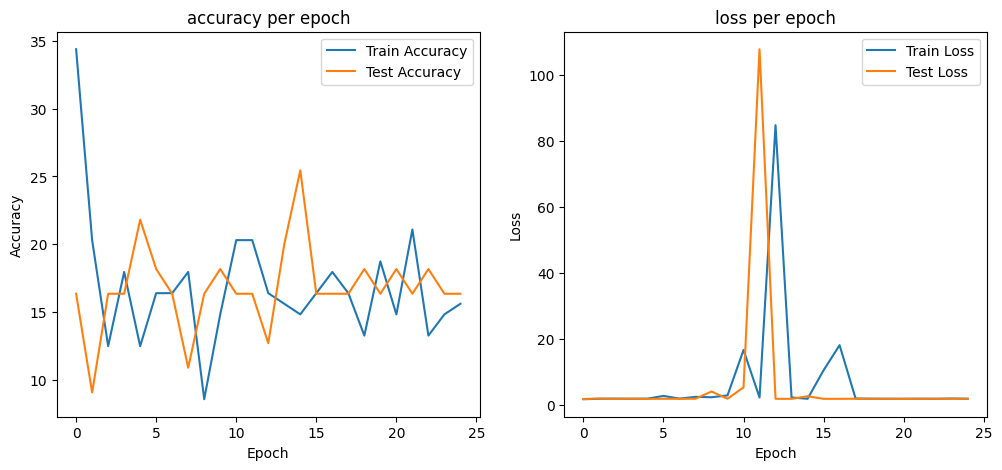

In [29]:
#final evaluation
efficientnet_model.eval()
y_true = []
y_pred = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = efficientnet_model(images)
        _, predicted = outputs.max(1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

final_test_accuracy = 100 * correct / total
print(f'Final Test Accuracy: {final_test_accuracy:.2f}%')

conf_matrix = confusion_matrix(y_true, y_pred)
cm_display = ConfusionMatrixDisplay(conf_matrix, display_labels=test_dataset.classes)


plt.figure(figsize=(12, 5))

#accuracy plots
plt.subplot(1, 2, 1)
plt.plot(train_acc_list, label='Train Accuracy')
plt.plot(test_acc_list, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('accuracy per epoch')

#loss plots
plt.subplot(1, 2, 2)
plt.plot(train_loss_list, label='Train Loss')
plt.plot(test_loss_list, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('loss per epoch')

plt.show()